In [1]:
from parcels import FieldSet, ParticleSet, JITParticle, AdvectionRK4, ScipyParticle
from glob import glob
from datetime import timedelta as delta
import datetime

import glob
import os

import xarray as xr
import matplotlib.pyplot as plt
import yaml

In [2]:
ciopse_dir='/home/nso001/data/work2/OPP/mldp-opendrift-comparison/models/ciopse/netcdf/'
hrdps_dir='/home/nso001/data/work2/OPP/mldp-opendrift-comparison/models/hrdps/netcdf/2022022400/shift_lon/'

# Particle initial positions

In [3]:
positions_file='/home/nso001/data/work2/OPP/mldp-opendrift-comparison/DriftMap/mldp/runs/ciops-e_ml_2022022400_P2D/drifter_positions.yaml'

with open(positions_file, 'r') as f:
    positions=yaml.load(f, Loader=yaml.FullLoader)
positions = positions['drifter_grid_positions']
lons = []
lats = []
for key in positions:
    lon,lat = positions[key]
    lons.append(lon)
    lats.append(lat)

# No Winds

In [4]:
ufiles = sorted(glob.glob(os.path.join(ciopse_dir, '*U_2D.nc')))
vfiles = sorted(glob.glob(os.path.join(ciopse_dir, '*V_2D.nc')))
mesh_mask = '/home/sdfo000/sitestore4/opp_drift_fa3/share_drift/CIOPSE_EXP24/mesh_mask.nc'

filenames = {'U': {'lon': mesh_mask, 'lat': mesh_mask, 'depth': mesh_mask, 'data': ufiles},
             'V': {'lon': mesh_mask, 'lat': mesh_mask, 'depth': mesh_mask, 'data': vfiles},}

variables = {'U': 'uos',
             'V': 'vos'}
dimensions = {'U': {'lon': 'glamf', 'lat': 'gphif', 'time': 'time_counter'},
              'V': {'lon': 'glamf', 'lat': 'gphif', 'time': 'time_counter'},}

fieldset = FieldSet.from_nemo(filenames, variables, dimensions)

pset = ParticleSet.from_list(fieldset=fieldset, pclass=JITParticle,
                             lon=lons,
                             lat=lats,
                             time=datetime.datetime(2022,2,24),
                             depth=None)

kernels = pset.Kernel(AdvectionRK4)
output_file = pset.ParticleFile(name="ocean_parcels_winds0.0.nc", outputdt=delta(hours=1))
pset.execute(kernels, runtime=delta(days=2), dt=delta(seconds=5),output_file=output_file)
output_file.close() 

INFO: Compiled ArrayJITParticleAdvectionRK4 ==> /tmp/parcels-67340/lib0328fa0c61a646de2775ee0a5dd508b8_0.so
INFO: Temporary output files are stored in out-CVGISXBL.
INFO: You can use "parcels_convert_npydir_to_netcdf out-CVGISXBL" to convert these to a NetCDF file during the run.
100% (172800.0 of 172800.0) |############| Elapsed Time: 0:00:44 Time:  0:00:44


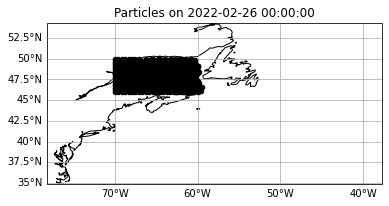

In [5]:
pset.show()

In [37]:
d = xr.open_dataset('ocean_parcels_winds0.0.nc')

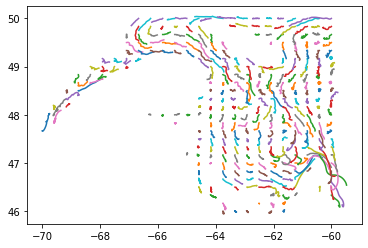

In [38]:
fig,ax = plt.subplots(1,1)
for t in range(d.trajectory.shape[0]):
    dsel=d.sel(traj=t)
    ax.plot(dsel.lon.values, dsel.lat.values)

In [39]:
d2 = xr.open_dataset('/home/nso001/data/work2/OPP/mldp-opendrift-comparison/DriftMap/new/opendrift-winds0.0/output/ciops-e_od_2022022400_P2D.nc')

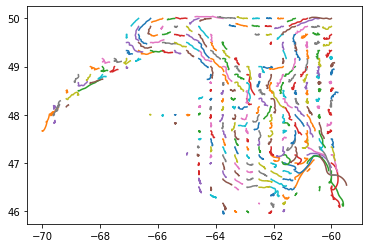

In [40]:
fig,ax = plt.subplots(1,1)

for t in range(d2.model_run.shape[0]):
    dsel=d2.sel(model_run=t)
    ax.plot(dsel.mod_lon.values, dsel.mod_lat.values)

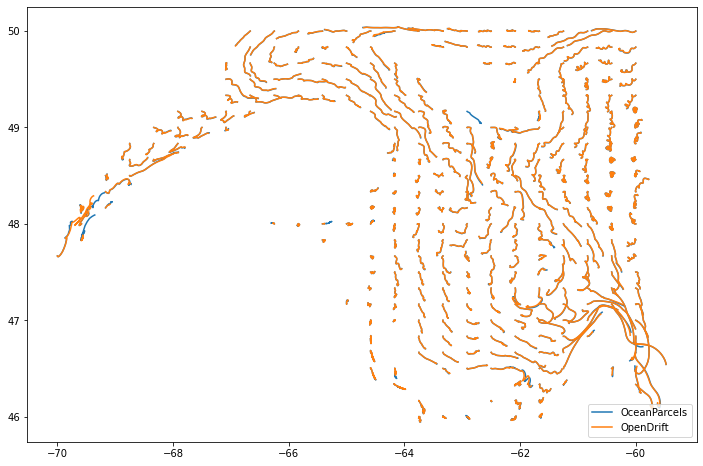

In [43]:
fig,ax = plt.subplots(1,1,figsize=(12,8))
count=0
for t in range(d.trajectory.shape[0]):
    label='OceanParcels' if count==0 else '_nolabel'
    dsel=d.sel(traj=t)
    ax.plot(dsel.lon.values, dsel.lat.values, 'C0', label=label)
    count+=1
count=0
for t in range(d2.model_run.shape[0]):
    label='OpenDrift' if count==0 else '_nolabel'
    dsel=d2.sel(model_run=t)
    ax.plot(dsel.mod_lon.values, dsel.mod_lat.values, 'C1', label=label)
    count+=1
ax.legend()
fig.savefig('OpenDriftvsOceanParcelsvsMDLP.png', bbox_inches='tight')

# Winds 3.0

In [11]:
#winds
wind_files = sorted(glob.glob(os.path.join(hrdps_dir, '*winds*.nc')))

dtry = xr.open_mfdataset(wind_files)
dtry = dtry.isel(x=slice(1500,2500), y=slice(0,1200))

u = dtry.u_wind.values
v = dtry.v_wind.values
nav_lon = dtry.nav_lon.values[0]
nav_lat = dtry.nav_lat.values[0]
time = dtry.time_counter.values

In [12]:
nav_lon.shape

(1200, 1000)

In [13]:
ufiles = sorted(glob.glob(os.path.join(ciopse_dir, '*U_2D.nc')))
vfiles = sorted(glob.glob(os.path.join(ciopse_dir, '*V_2D.nc')))
mesh_mask = '/home/sdfo000/sitestore4/opp_drift_fa3/share_drift/CIOPSE_EXP24/mesh_mask.nc'

filenames = {'U': {'lon': mesh_mask, 'lat': mesh_mask, 'depth': mesh_mask, 'data': ufiles},
             'V': {'lon': mesh_mask, 'lat': mesh_mask, 'depth': mesh_mask, 'data': vfiles},}

variables = {'U': 'uos',
             'V': 'vos'}
dimensions = {'U': {'lon': 'glamf', 'lat': 'gphif', 'time': 'time_counter'},
              'V': {'lon': 'glamf', 'lat': 'gphif', 'time': 'time_counter'},}

ocean_fieldset = FieldSet.from_nemo(filenames, variables, dimensions)


windage=0.03
variables = {'U': windage*u,
             'V': windage*v}
dimensions = {'U': {'lon': nav_lon, 'lat': nav_lat, 'time': time},
              'V': {'lon': nav_lon, 'lat': nav_lat, 'time': time},}


wind_fieldset = FieldSet.from_data(variables, dimensions)
#wind_fieldset.U.set_scaling_factor(windage)
#wind_fieldset.V.set_scaling_factor(windage)



fieldset = FieldSet(U=ocean_fieldset.U+wind_fieldset.U, 
                    V=ocean_fieldset.V+wind_fieldset.V)


pset = ParticleSet.from_list(fieldset=fieldset, pclass=JITParticle,
                             lon=lons,
                             lat=lats,
                             time=datetime.datetime(2022,2,24),
                             depth=None)
#pset.populate_indices()
kernels = pset.Kernel(AdvectionRK4)
output_file = pset.ParticleFile(name="ocean_parcels_winds3.0.nc", outputdt=delta(hours=1))
pset.execute(kernels, runtime=delta(days=2), dt=delta(seconds=5),output_file=output_file)
output_file.close() 

INFO: Compiled ArrayJITParticleAdvectionRK4 ==> /tmp/parcels-67340/lib1eef15d0c320b2d61ea70f31450bb028_0.so
INFO: Temporary output files are stored in out-ZHCFHLZH.
INFO: You can use "parcels_convert_npydir_to_netcdf out-ZHCFHLZH" to convert these to a NetCDF file during the run.
100% (172800.0 of 172800.0) |############| Elapsed Time: 0:01:28 Time:  0:01:28


In [14]:
pset.show()

AttributeError: 'SummedField' object has no attribute 'grid'

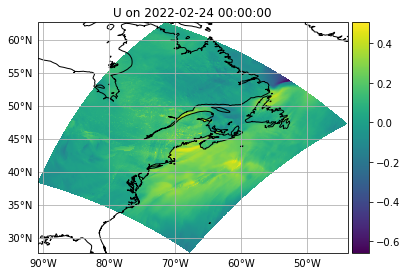

In [15]:
wind_fieldset.U.show()

In [45]:
d = xr.open_dataset('ocean_parcels_winds3.0.nc')
d2 = xr.open_dataset('/home/nso001/data/work2/OPP/mldp-opendrift-comparison/DriftMap/new/opendrift-winds3.0/output/ciops-e_od_2022022400_P2D.nc')

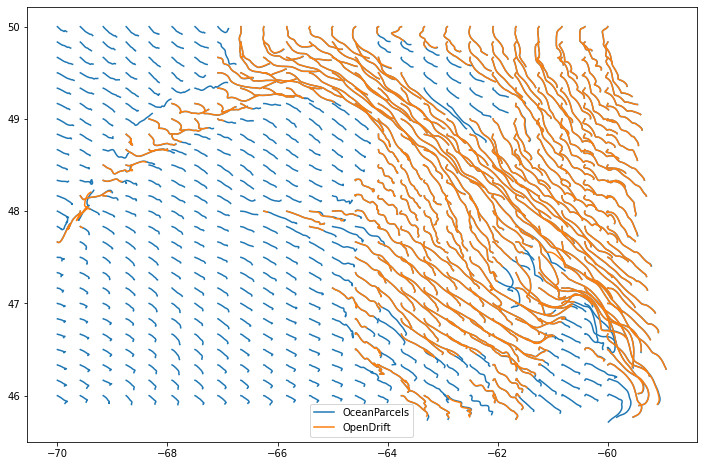

In [47]:
fig,ax = plt.subplots(1,1,figsize=(12,8))
count=0
for t in range(d.trajectory.shape[0]):
    label='OceanParcels' if count==0 else '_nolabel'
    dsel=d.sel(traj=t)
    ax.plot(dsel.lon.values, dsel.lat.values, 'C0', label=label)
    count+=1
count=0
for t in range(d2.model_run.shape[0]):
    label='OpenDrift' if count==0 else '_nolabel'
    dsel=d2.sel(model_run=t)
    ax.plot(dsel.mod_lon.values, dsel.mod_lat.values, 'C1', label=label)
    count+=1
ax.legend()
fig.savefig('OpenDriftvsOceanParcels.png', bbox_inches='tight')

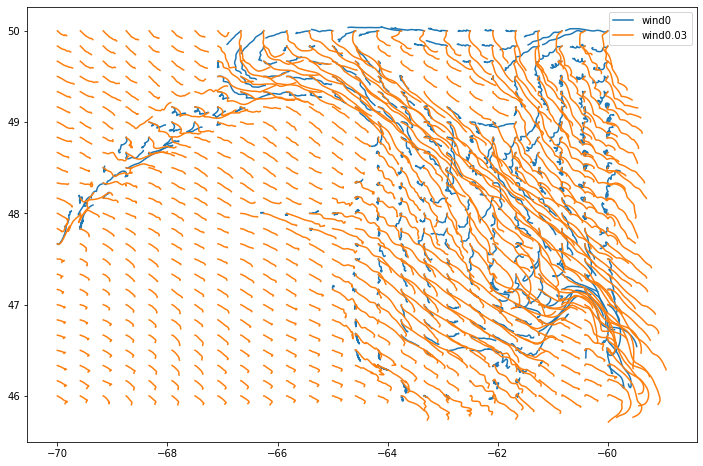

In [33]:
d = xr.open_dataset('ocean_parcels_winds0.0.nc')
d2 = xr.open_dataset('ocean_parcels_winds3.0.nc')
fig,ax = plt.subplots(1,1,figsize=(12,8))
count=0
for t in range(d.trajectory.shape[0]):
    label='wind0' if count==0 else '_nolabel'
    dsel=d.sel(traj=t)
    ax.plot(dsel.lon.values, dsel.lat.values, 'C0', label=label)
    count+=1
count=0
for t in range(d2.trajectory.shape[0]):
    label='wind0.03' if count==0 else '_nolabel'
    dsel=d2.sel(traj=t)
    ax.plot(dsel.lon.values, dsel.lat.values, 'C1', label=label)
    count+=1
ax.legend()
#fig.savefig('OpenDriftvsOceanParcels.png', bbox_inches='tight')

How to handle grounding in parcels?? Is there a way to mask the data over land?
